Entrenamiento de Modelo LSTM para Predicción de Temperatura
Usando 3 features del dataset meteorológico
Este notebook entrena un modelo LSTM usando solo 4 columnas del dataset_ml.csv:

Features seleccionadas:

ts: Temperatura del Aire Seco (°C) → [OBJETIVO A PREDECIR]
hr: Humedad Relativa del aire (%)
p0: Presión leída del sensor (hPa)
Tambien utilizar momento a lo que se refiere a la hora
Este enfoque simplificado permite:

✅ Entrenamiento más rápido
✅ Modelo más ligero
✅ Fácil de mapear con datos de Arduino (temperatura, humedad, presión)
✅ Menos riesgo de overfitting

1. Cargar y explorar datos

==================================================
MODELO CLIMÁTICO LIGERO (TensorFlow Lite + Raspberry Pi)
==================================================

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import joblib
import warnings
warnings.filterwarnings('ignore')

In [68]:
# Cargar datos del dataset completo
csv_path = "datos_rellenados1.csv"
df = pd.read_csv(csv_path, sep=";", decimal=".", encoding="utf-8")

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

print(f"✅ Datos cargados")
print(f"   Total de registros: {len(df):,}")
print(f"   Columnas: {list(df.columns)}")
print(f"\n📊 Primeras filas:")
df.head(10)

✅ Datos cargados
   Total de registros: 3,546,082
   Columnas: ['momento', 'ts', 'td', 'tMin12Horas', 'tMax12Horas', 'horaTMin12Horas', 'horaTMax12Horas', 'momentoRegistro_x', 'hr', 'p0', 'qfe1', 'qff', 'qnh', 'momentoRegistro_y']

📊 Primeras filas:


,momento,ts,td,tMin12Horas,tMax12Horas,horaTMin12Horas,horaTMax12Horas,momentoRegistro_x,hr,p0,qfe1,qff,qnh,momentoRegistro_y
0,2019-01-01 00:00:00,23.6,4.5,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:02:06,28.8,950.4,950.5,1009.1,1011.4,2019-01-01 00:02:06
1,2019-01-01 00:01:00,23.6,4.4,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:06:01,28.8,950.4,950.5,1009.1,1011.4,2019-01-01 00:06:01
2,2019-01-01 00:02:00,23.6,4.5,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:06:01,29.0,950.4,950.6,1009.2,1011.4,2019-01-01 00:06:01
3,2019-01-01 00:03:00,23.5,4.4,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:06:01,29.1,950.4,950.6,1009.2,1011.4,2019-01-01 00:06:01
4,2019-01-01 00:04:00,23.5,4.5,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:06:01,29.2,950.4,950.5,1009.0,1011.3,2019-01-01 00:06:01
5,2019-01-01 00:05:00,23.4,4.5,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:06:01,29.1,950.5,950.6,1009.3,1011.4,2019-01-01 00:06:01
6,2019-01-01 00:06:00,23.4,4.3,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:12:01,28.9,950.5,950.6,1009.3,1011.4,2019-01-01 00:12:01
7,2019-01-01 00:07:00,23.4,4.3,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:12:01,29.0,950.4,950.6,1009.3,1011.4,2019-01-01 00:12:01
8,2019-01-01 00:08:00,23.4,4.3,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:12:01,28.9,950.5,950.5,1009.2,1011.4,2019-01-01 00:12:01
9,2019-01-01 00:09:00,23.3,4.3,21.0,32.3,2018-12-31 12:12:00,2018-12-31 20:12:00,2019-01-01 00:12:01,29.0,950.5,950.6,1009.3,1011.4,2019-01-01 00:12:01


=== Cargar dataset ===

In [69]:
csv_path = "datos_rellenados1.csv"
df = pd.read_csv(csv_path, sep=";", decimal=".", encoding="utf-8")
df.columns = df.columns.str.strip()
print(f"✅ Datos cargados: {len(df):,} registros")

✅ Datos cargados: 3,546,082 registros


=== Convertir columna 'momento' a datetime ===

In [70]:
df["momento"] = pd.to_datetime(df["momento"], errors="coerce")

=== Re-muestrear por hora (promediar cada hora) ===

In [71]:
#=== Re-muestrear por hora (promediar cada hora) ===
#df.set_index("momento") Coloca la columna "momento" como índice del DataFrame.
#.resample("1H")Agrupa los datos en intervalos de 1 hora exacta (por ejemplo: 10:00, 11:00, 12:00, etc.).
#.mean() Calcula el promedio de todas las columnas numéricas dentro de cada grupo horario.
#.reset_index() Devuelve la columna "momento" como columna normal en vez de índice.

# Select only numeric columns before resampling
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df = df.set_index("momento")[numeric_cols].resample("1H").mean().reset_index()
print("✅ Datos muestreados por hora")

✅ Datos muestreados por hora


In [72]:
#=== Agregar variables temporales ===

df["timestamp"] = df["momento"].astype(np.int64) / 1e9
df["hora"] = df["momento"].dt.hour
df["dia_semana"] = df["momento"].dt.weekday
df["mes"] = df["momento"].dt.month


In [73]:
#=== Seleccionar features ===
#=== Seleccionar features ===

feature_cols = ['ts', 'hr', 'p0', 'hora']
df_selected = df[feature_cols]

print(f"✅ Features seleccionadas: {feature_cols}")
print(f" Total de registros: {len(df_selected):,}")


✅ Features seleccionadas: ['ts', 'hr', 'p0', 'hora']
 Total de registros: 59,161


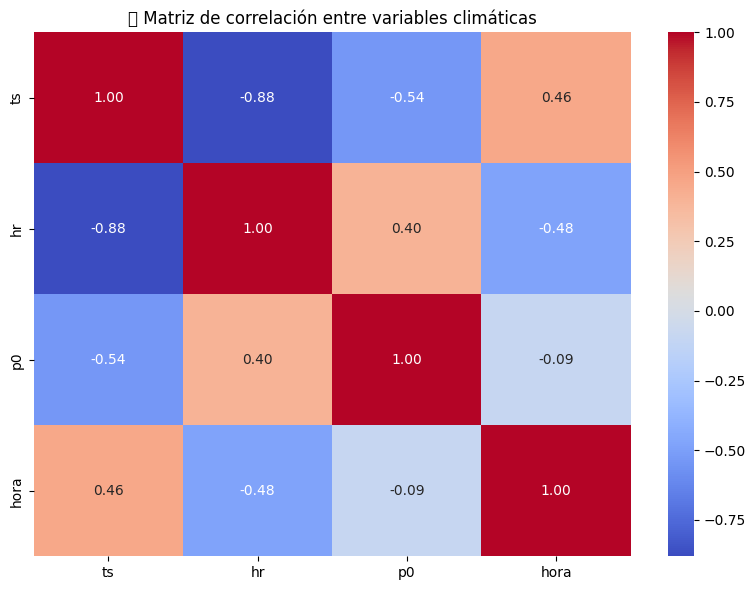

✅ Escalado completado y guardado: scaler_ligero.pkl


In [74]:
#=== Matriz de correlación ===

plt.figure(figsize=(8, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Matriz de correlación entre variables climáticas")
plt.tight_layout()
plt.show()

#=== Escalado ===

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_selected)
scaler_path = "scaler_ligero.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Escalado completado y guardado: {scaler_path}")


In [75]:
#=== Crear secuencias ===

def crear_secuencias(datos, pasos=24, col_obj=0):
  X, y = [], []
  for i in range(pasos, len(datos)):
    X.append(datos[i-pasos:i])
    y.append(datos[i, col_obj])
  return np.array(X), np.array(y)

n_pasos = 24
X, y = crear_secuencias(data_scaled, pasos=n_pasos, col_obj=0)
print(f"✅ Secuencias creadas: X={X.shape}, y={y.shape}")

✅ Secuencias creadas: X=(59137, 24, 4), y=(59137,)


In [76]:
#=== División 60% / 20% / 20% ===

n_total = len(X)
n_train = int(n_total * 0.6)
n_val = int(n_total * 0.2)

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

print(f"✅ División de datos:")
print(f" Entrenamiento: {len(X_train)}")
print(f" Validación: {len(X_val)}")
print(f" Prueba: {len(X_test)}")

✅ División de datos:
 Entrenamiento: 35482
 Validación: 11827
 Prueba: 11828


In [77]:
# === Modelo LSTM liviano (2 capas LSTM) ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_pasos, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,353 (118.57 KB)

 Trainable params: 30,353 (118.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#=== Callbacks ===

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint("modelo_clima_best.h5", save_best_only=True)

#=== Entrenamiento ===

history = model.fit(
X_train, y_train,
validation_data=(X_val, y_val),
epochs=40,
batch_size=32,
callbacks=[early_stop, checkpoint],
verbose=1
)

Epoch 1/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/40
 111/1109 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: nan - mae: nan

In [ ]:
#=== Evaluar en test ===

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 RESULTADOS FINAL:")
print(f" MSE: {loss:.4f} | MAE: {mae:.4f}")

In [ ]:
#=== Guardar modelo ===

model.save("modelo_clima_ligero.h5")
print("💾 Modelo guardado: modelo_clima_ligero.h5")

In [46]:
#==================================================
#CONVERSIÓN A TENSORFLOW LITE
#==================================================

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with open("modelo_clima_ligero.tflite", "wb") as f:
  f.write(tflite_model)
print("💡 Conversión exitosa → modelo_clima_ligero.tflite")

#=== Cuantización FP16 (opcional) ===

converter.target_spec.supported_types = [tf.float16]
tflite_model_fp16 = converter.convert()
with open("modelo_clima_ligero_fp16.tflite", "wb") as f:
  f.write(tflite_model_fp16)
print("✅ Modelo cuantizado FP16 guardado (para Raspberry Pi)")

Saved artifact at '/tmp/tmpr14vmoxn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 4), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139806521813584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806521817232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806397114000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806397112272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806397114192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806397113040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806521817808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806521816080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806521811472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139806521815696: TensorSpec(shape=(), dtype=tf.resource, name=None)
💡 Conversión exitos

In [ ]:
#=== Verificar valores NaN antes de calcular métricas ===
import numpy as np

# Revisar si hay NaN en las predicciones o reales
print("🔍 Revisando NaN...")
print(f"NaN en y_pred_real: {np.isnan(y_pred_real).sum()}")
print(f"NaN en y_true_real: {np.isnan(y_true_real).sum()}")

# Eliminar filas con NaN
mask = ~np.isnan(y_true_real) & ~np.isnan(y_pred_real)
y_true_real = y_true_real[mask]
y_pred_real = y_pred_real[mask]

print(f"✅ Filas válidas: {len(y_true_real)} (eliminadas {len(mask) - mask.sum()})")
print("Scaler entrenado con columnas:", data_scaled.shape[1])
print("Dummy shape:", dummy_pred.shape)
print("Predicciones shape:", y_pred_scaled.shape)



In [ ]:
#==================================================
#EVALUACIÓN COMPLETA (MAE, MSE, R², confianza)
#==================================================
#=== Verificar valores NaN antes de calcular métricas ===

y_pred_scaled = model.predict(X_test)
dummy_pred = np.zeros((len(y_pred_scaled), data_scaled.shape[1]))
dummy_pred[:, 0] = y_pred_scaled.flatten()
y_pred_real = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_true = np.zeros((len(y_test), data_scaled.shape[1]))
dummy_true[:, 0] = y_test
y_true_real = scaler.inverse_transform(dummy_true)[:, 0]

mae_real = mean_absolute_error(y_true_real, y_pred_real)
mse_real = mean_squared_error(y_true_real, y_pred_real)
r2 = r2_score(y_true_real, y_pred_real)
confianza = max(0, min(100, r2 * 100))

print("\n📈 MÉTRICAS EN ESCALA REAL:")
print(f" - MAE: {mae_real:.3f}")
print(f" - MSE: {mse_real:.3f}")
print(f" - R²: {r2:.3f}")
print(f" - Confianza: {confianza:.1f}%")

#=== Gráficos ===

plt.figure(figsize=(14, 5))
plt.plot(y_true_real[:300], label="Real", alpha=0.8)
plt.plot(y_pred_real[:300], label="Predicho", alpha=0.8)
plt.title("Predicciones vs Valores Reales (muestras de prueba)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#--- Gráfico de métricas ---

metricas = {"MAE": mae_real, "MSE": mse_real, "R²": r2}
plt.figure(figsize=(6, 4))
sns.barplot(x=list(metricas.keys()), y=list(metricas.values()), palette="viridis")
plt.title("Comparación de Métricas del Modelo")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
#==================================================
#GUARDAR MODELO FINAL Y RESUMEN
#==================================================

model_path = "modelo_lstm_3_features.h5"
model.save(model_path)

print(f"\n✅ ARCHIVOS GUARDADOS:")
print(f" 📦 Modelo: {model_path}")
print(f" 📦 Scaler: {scaler_path}")
print(f"\n🎉 ¡Entrenamiento completado exitosamente!")
print(f"\n📝 Configuración del modelo:")
print(f" - Dataset: dataset_ml.csv")
print(f" - Features: 3 columnas (ts, hr, p0)")
print(f" - Timesteps: {n_pasos}")
print(f" - MAE: {mae_real:.3f} °C")
print(f" - Objetivo: Predecir 'ts' (Temperatura del Aire Seco)")
print(f" - Confianza: {confianza:.1f}%")
print(f"\n💡 Ahora puedes usar el modelo con 'predecir_simple.py'")